<a href="https://colab.research.google.com/github/Jingqi-Wang0416/MUSA-6950-Final-Project/blob/main/Final_Project_Jingqi_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load Miami neighborhoods shapefile
neighborhoods = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Miami_Neighborhoods_Shapefile.geojson")
neighborhoods = neighborhoods.to_crs(epsg=3857)

# Load Census Tracts shapefile (with population data)
tracts = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/Tract.shp")
tracts = tracts.to_crs(epsg=3857)

print(f"Neighborhoods loaded: {len(neighborhoods)}")
print(f"Census tracts loaded: {len(tracts)}")


Neighborhoods loaded: 107
Census tracts loaded: 707


In [ ]:
# Check for population field and prepare
if "POP100" not in tracts.columns:
    raise ValueError("No population field found in Census tracts!")

tracts = tracts.rename(columns={"POP100": "population"})

# Confirm
tracts[["GEOID", "population"]].head()


,GEOID,population
0,1400000US12086009010,8427
1,1400000US12086005304,4321
2,1400000US12086009028,5819
3,1400000US12086010621,4764
4,1400000US12086009060,5452


In [ ]:
# Perform spatial join: assign each tract to a neighborhood
joined = gpd.sjoin(tracts, neighborhoods, how="inner", predicate="intersects")

# Group by neighborhood and sum population
pop_by_neigh = joined.groupby("LABEL")["population"].sum().reset_index()

# Merge back to neighborhoods shapefile
neighborhoods = neighborhoods.merge(pop_by_neigh, on="LABEL", how="left")

# Fill missing populations (e.g., no intersecting tracts) with 0
neighborhoods["population"] = neighborhoods["population"].fillna(0).astype(int)

# Confirm
neighborhoods[["LABEL", "population"]].sort_values(by="population", ascending=False).head(10)


,LABEL,population
60,Flagami,67512
96,East Little Havana,52649
74,Douglas Park,48700
56,South Sewell Park,47134
33,Santa Clara,46839
58,Citrus Grove,45520
59,Auburndale,36893
91,Brickell Business District,36137
41,Allapattah Industrial District,34515
51,North Sewell Park,34229


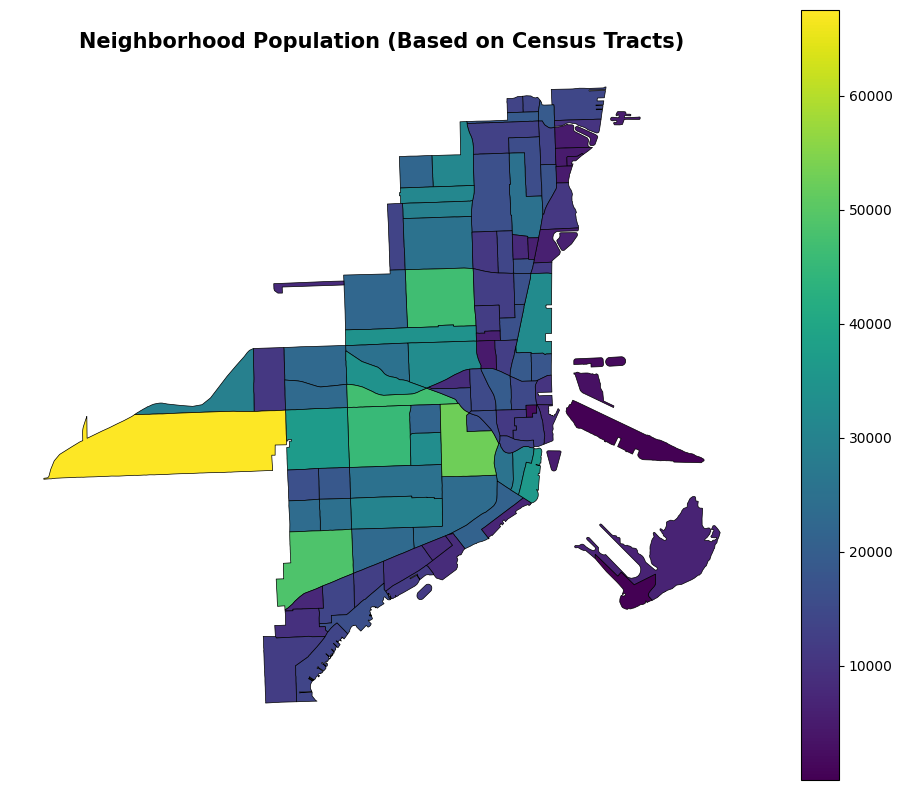

In [ ]:
# Visualization
fig, ax = plt.subplots(figsize=(12, 10))
neighborhoods.plot(
    ax=ax,
    column="population",
    cmap="viridis",
    legend=True,
    edgecolor="black",
    linewidth=0.5
)
plt.title("Neighborhood Population (Based on Census Tracts)", fontsize=15, fontweight="bold")
plt.axis("off")
plt.show()


In [ ]:
# Load uncovered landmark data
uncovered = gpd.read_file("/content/drive/MyDrive/Colab Notebooks/Miami/uncovered_landmarks.geojson")
uncovered = uncovered.to_crs(epsg=3857)

print(f"Uncovered landmarks loaded: {len(uncovered)}")


Uncovered landmarks loaded: 296


In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np

# Prepare coordinates for clustering
coords = np.array(list(zip(uncovered.geometry.x, uncovered.geometry.y)))

# Run DBSCAN
db = DBSCAN(eps=300, min_samples=3)
uncovered["cluster"] = db.fit_predict(coords)

In [ ]:
# Match each uncovered landmark to its containing neighborhood
uncovered_with_neigh = gpd.sjoin(uncovered, neighborhoods, how="left", predicate="within")

In [ ]:
# Only keep landmarks that belong to a cluster
clustered_landmarks = uncovered_with_neigh[uncovered_with_neigh["cluster"] != -1].copy()

# Group by neighborhood and cluster
cluster_summary = clustered_landmarks.groupby(["LABEL", "cluster"]).agg(
    landmark_count=("LMNAME", "count")
).reset_index()

# Merge neighborhood population
cluster_summary = cluster_summary.merge(neighborhoods[["LABEL", "population"]], on="LABEL", how="left")

# Compute weighted score: (number of uncovered landmarks) * (population)
cluster_summary["weighted_score"] = cluster_summary["landmark_count"] * cluster_summary["population"]

# Sort by highest weighted score
cluster_summary_sorted = cluster_summary.sort_values(by="weighted_score", ascending=False)

# Display top results
cluster_summary_sorted.head(10)


,LABEL,cluster,landmark_count,population,weighted_score
6,CBD,0,21,12300,258300
17,Government Center,0,21,11185,234885
10,Civic Center,16,5,32581,162905
45,South Sewell Park,11,3,47134,141402
33,North Sewell Park,11,4,34229,136916
3,Brickell Village,0,4,30883,123532
22,Le Jeune Gardens,9,4,29242,116968
13,East Little Havana,0,2,52649,105298
28,Miami Avenue,14,5,21005,105025
9,Civic Center,4,3,32581,97743


In [ ]:
# Calculate the number of uncovered landmarks per neighborhood
landmark_counts = uncovered_with_neigh.groupby("LABEL").size().reset_index(name="landmark_count")

# Merge landmark counts into neighborhoods
neighborhoods = neighborhoods.merge(landmark_counts, on="LABEL", how="left")
neighborhoods["landmark_count"] = neighborhoods["landmark_count"].fillna(0).astype(int)

# Calculate priority score: landmarks count multiplied by neighborhood population
neighborhoods["priority_score"] = neighborhoods["landmark_count"] * neighborhoods["population"]


In [ ]:
# Sort neighborhoods by priority score and select the top 10
top10_neigh = neighborhoods.sort_values(by="priority_score", ascending=False).head(10)

# Select and format relevant columns
top10_table = top10_neigh[["LABEL", "landmark_count", "population", "priority_score"]].reset_index(drop=True)
top10_table["priority_score"] = top10_table["priority_score"].round(2)

# Display the table
import pandas as pd
pd.set_option("display.max_columns", None)
print("Top 10 Neighborhoods by Uncovered Landmarks × Population Priority")
top10_table


Top 10 Neighborhoods by Uncovered Landmarks × Population Priority


,LABEL,landmark_count,population,priority_score
0,Civic Center,15,32581,488715
1,East Little Havana,8,52649,421192
2,South Sewell Park,7,47134,329938
3,Citrus Grove,6,45520,273120
4,CBD,21,12300,258300
5,North Sewell Park,7,34229,239603
6,Government Center,21,11185,234885
7,Flagami,3,67512,202536
8,Edgewater,6,32279,193674
9,Santa Clara,4,46839,187356


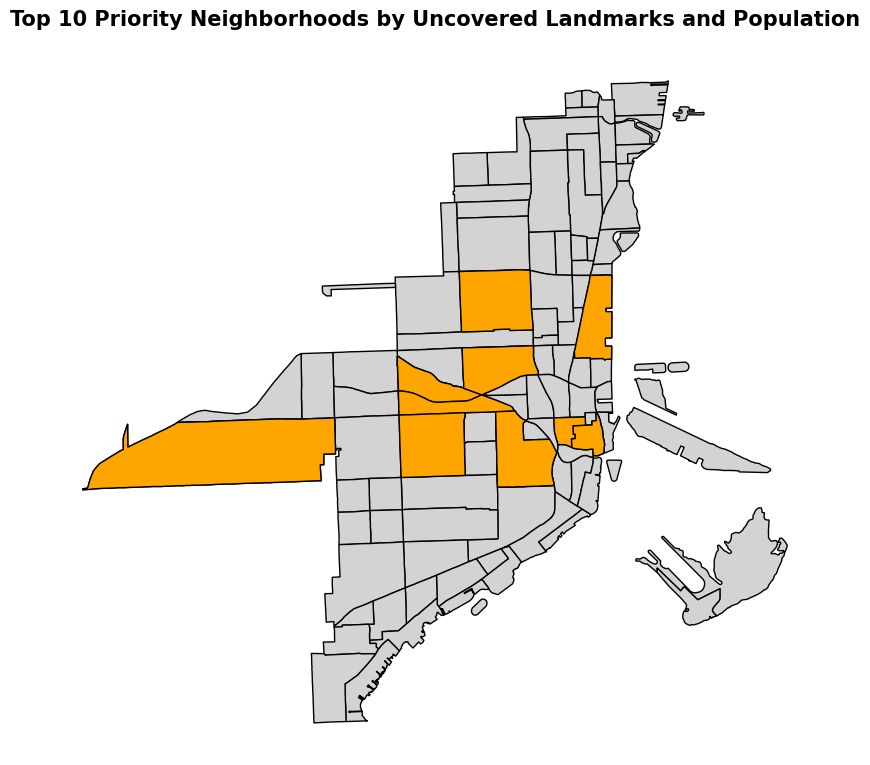

In [ ]:
import matplotlib.pyplot as plt

# Create a column to indicate top 10 neighborhoods
neighborhoods["is_top10"] = neighborhoods["LABEL"].isin(top10_table["LABEL"])

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
neighborhoods.plot(ax=ax, color="lightgray", edgecolor="black")
neighborhoods[neighborhoods["is_top10"]].plot(ax=ax, color="orange", edgecolor="black")

# Add title
plt.title("Top 10 Priority Neighborhoods by Uncovered Landmarks and Population", fontsize=15, fontweight="bold")
plt.axis("off")
plt.show()


<ipython-input-47-b6b192cdff38>:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  zoom_area = neighborhoods[neighborhoods["is_top10"]].unary_union.envelope.buffer(1000)


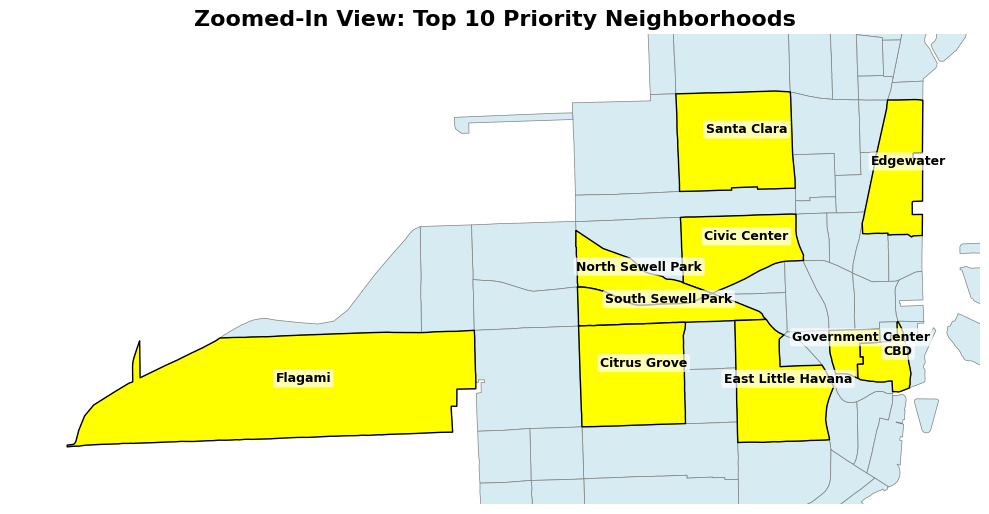

In [ ]:
# Define zoom-in area based on top 10 neighborhoods
zoom_area = neighborhoods[neighborhoods["is_top10"]].unary_union.envelope.buffer(1000)

# Create zoomed-in plot with improved color and labeling
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all neighborhoods with light blue background
neighborhoods.plot(ax=ax, color="#d6ebf2", edgecolor="gray", linewidth=0.5)

# Highlight top 10 priority neighborhoods in yellow
neighborhoods[neighborhoods["is_top10"]].plot(ax=ax, color="yellow", edgecolor="black", linewidth=1.0)

# Add neighborhood names with slight offset to avoid overlap
for idx, row in neighborhoods[neighborhoods["is_top10"]].iterrows():
    centroid = row.geometry.centroid
    ax.text(
        centroid.x + 200, centroid.y + 200,  # slight shift in x and y
        row["LABEL"],
        fontsize=9,
        ha="center",
        va="center",
        fontweight="bold",
        color="black",
        backgroundcolor="white",
        bbox=dict(facecolor="white", alpha=0.7, edgecolor="none", boxstyle="round,pad=0.2")
    )

# Set map extent to zoom area
ax.set_xlim(zoom_area.bounds[0], zoom_area.bounds[2])
ax.set_ylim(zoom_area.bounds[1], zoom_area.bounds[3])

# Final plot formatting
plt.title("Zoomed-In View: Top 10 Priority Neighborhoods", fontsize=16, fontweight="bold")
plt.axis("off")
plt.tight_layout()
plt.show()
